In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_path = '../data/bird_data'
n_images = 21

In [60]:
img1 = plt.imread(os.path.join(data_path, "images", "0004.ppm"))
img2 = plt.imread(os.path.join(data_path, "images", "0005.ppm"))

In [74]:
h, w, _ = img1.shape

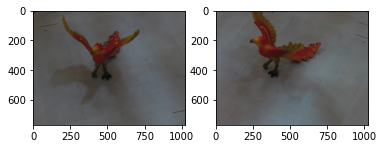

In [66]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(img1)
f.add_subplot(1,2,2)
plt.imshow(img2)
plt.show()

In [89]:
def compute_F(K, t, R, K_):
    F = np.linalg.inv(K.T) @ np.cross(t, R @ np.linalg.inv(K_), axisc=0)
    return F / F.max()

In [90]:
f = 2

K = f*np.eye(3)
K[2,2] = 1

K_ = f*np.eye(3)
K_[2,2] = 1

R = np.eye(3)

t = np.array([0,0,5])

In [91]:
F = compute_F(K, t, R, K_)
F

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [160]:
# x = (X, Y, w)
def x_to_img_coordinates(x):
    return int(x[0]/x[2]) + w//2, h//2 - int(x[1]/x[2])

In [159]:
# x = (X, Y, w)
def scatter(x):
    i, j = x_to_img_coordinates(x)
    plt.scatter([i], [j], c='r')

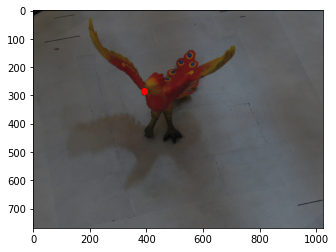

In [125]:
x = np.array([-120, 100, 1])

plt.imshow(img1)
scatter(x)
plt.show()

In [126]:
l = F @ x

In [127]:
def epipolar_y(x, l):
    return (-l[2] - l[0]*x)/l[1]

In [157]:
def plot_epipolar_line(img, l):
    plt.imshow(img)
    X, Y = [], []
    x = -w//2
    while True:
        y = epipolar_y(x, l)
        x_, y_ = x_to_img_coordinates([x, y, 1])
        if y_ >= 0 and y_ < h:
            X.append(x_)
            Y.append(y_)
            break
        x += 1
    x = w//2
    while True:
        y = epipolar_y(x, l)
        x_, y_ = x_to_img_coordinates([x, y, 1])
        if y_ >= 0 and y_ < h:
            X.append(x_)
            Y.append(y_)
            break
        x -= 1
    plt.plot(X, Y, 'r')
    plt.show()

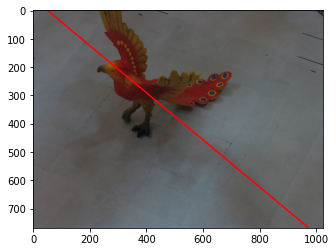

In [158]:
plot_epipolar_line(img2, F @ x)